In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

import math

from sklearn import preprocessing

from scipy import stats
import scipy as sci

import random

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV

from scipy.spatial.distance import minkowski

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
#Mount  Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Colab\ Notebooks/ML\ Project2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/ML Project2


# Import Dataset

In [3]:
df = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip')

In [4]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.drop(columns = 'Kmer', inplace = True)

In [5]:
y = df['relKa'].to_numpy()
x = df.loc[:, df.columns != 'relKa'].to_numpy()

# Split to 0 & 1

In [6]:
def split_importance(x,y,importance_class=0.7):
  """
  Split the samples into interesting ones and not interesting ones
  :param x: numpy.ndarray:the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param importance_class: float: the lower bound for the underepresented class
  """
  return x[y>=importance_class], y[y>=importance_class], x[y<importance_class], y[y<importance_class]

In [7]:
x_1,y_1,x_0,y_0 = split_importance(x,y)

# Train - Test Split

In [8]:
# split the two classes seperately into train and test set to ensure representation of the minority class
# both in the test set and in the train set
x_1_train,x_1_test,y_1_train,y_1_test = train_test_split(x_1, y_1, test_size=0.30, random_state=42)
x_0_train,x_0_test,y_0_train,y_0_test = train_test_split(x_0, y_0, test_size=0.30, random_state=42)

x_train = np.concatenate((x_1_train,x_0_train))
y_train = np.concatenate((y_1_train,y_0_train))
x_test = np.concatenate((x_1_test,x_0_test))
y_test = np.concatenate((y_1_test,y_0_test))

# Remove Outliers

In [9]:
# Worse performances
def Anomaly_Detection_Isolation_Forests(x, change_split=True):
  random_state = np.random.RandomState(42)
  contamination = 'auto'
  threshold = np.random.uniform(-0.03, -0.02, 1)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  if change_split == False:
    anomaly_score = model.predict(x)
    outliers_indices = np.where(anomaly_score == -1)[0]
  if change_split == True:
    outliers_indices = split_outliers(threshold, scores)
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  if contamination != 'auto':
    outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
    assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(y) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)
    print("The percentage of outliers detected is", 1 / len(scores) * len(np.where(scores < 0)[0]))

def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

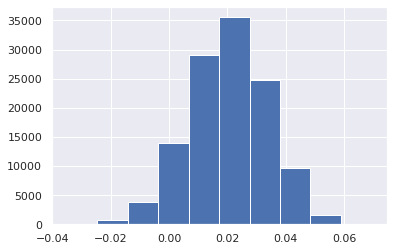

The indecision percentage around 0.02 is 0.3352659440383161
The percentage of outliers detected is 0.06591796057149557


In [10]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(x_train, change_split=False)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [11]:
x_train, y_train = drop_outliers(x_train, y_train, outliers_indices)

# Feature Manipulation

In [12]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Boxcox Transformation

In [13]:
y_train, fitted_lambda= stats.boxcox(list(y_train),lmbda=None)
#print(fitted_lambda)
#print(stats.boxcox([0.7,1], fitted_lambda))
y_train = np.array(y_train)
print(fitted_lambda)

-1.0008549422054305


# Smote Sampling 

In [14]:
def Fisher_Score(x_import,x_nimport):
  """
  Given two arrays of two classes this function calculates the Fischer_scores to 
  measure the significance for all features
  :param x_import: numpy.ndarray: the array containing the samples of one class
  :param x_nimport: numpy.ndarray: the array containing the samples of the other class
  :return: numpy.ndarray: returns an array containg the Fisher_Score for all features 
  """
  mean_import = np.mean(x_import,axis = 0)
  mean_nimport = np.mean(x_nimport,axis = 0)
  mean_dist = np.absolute(mean_import-mean_nimport)
  std_import = np.std(x_import,axis=0)
  std_nimport = np.std(x_nimport,axis=0)
  std_sum = std_import+std_nimport
  #return std_sum
  return np.divide(mean_dist,std_sum)

def calculate_distances(x,distance):
  """
  Calculates the distance between any two pairs of the set x using 
  the Minkowski distance of degree distance.
  :param x: numpy.ndarray: the vector for which we will calculate the distance 
                            between all of its elements 
  :param distance: float: the norm which should be used for the Minkowski distance
  :return: numpy.ndarray: returns the Minkowski distance with the specified norm 
                          between all pairs of elements in x 
  """
  dist = np.array([[minkowski(a1,a2,distance) for a2 in x] for a1 in x])
  np.fill_diagonal(dist,float('inf'))
  return dist

def random_sampler(x,y,randomsize):
  """
  This function does random undersampling of vectors x,y and reduces them to 
  size random size
  :param x: numpy.ndarray: the feature vector to be subsampled
  :param y: numpy.ndarray: the label vector to be subsampled
  :return: <class 'tuple'>: A tuple containing the two undersampled vectors
  """
  p = np.random.permutation(len(y))
  new_x = x[p]
  new_y = y[p]
  return new_x[:randomsize],new_y[:randomsize]

def generate_samples(x,y,neighbors,N):
  """
  This function generate N samples which are convex combinations of 
  the features of x and the labels of y
  :param x: numpy.ndarray:
  :param y: numpy.ndarray:
  :return: <class 'tuple'>:
  """
  new_samples_x = []
  new_samples_y = []
  for i in range(N):
    random_sample_i = random.randint(0,y.shape[0]-1)
    x_i = x[random_sample_i]
    random_sample_j = random.randint(0,neighbors.shape[1]-1)
    neigh_i = neighbors[random_sample_i,random_sample_j]
    x_j = x[neigh_i]
    lambda_ = random.uniform(0,1)
    y_i = y[random_sample_i]
    y_j = y[neigh_i]
    new_x = x_i + lambda_*(x_j-x_i)
    new_y = y_i + lambda_*(y_j-y_i)
    new_samples_x.append(new_x)
    new_samples_y.append(new_y)
  return np.array(new_samples_x),np.array(new_samples_y)

def smote_sf(x, y, undersample=0.5, oversample = 0.1, attribute_scorer=Fisher_Score, 
             attribute_number = 10, distance = float('inf'), kneighbors = 3,
             undersampling = random_sampler, importance_class = 0.7):
  """
  This function takes the complete input and produces a more balanced dataset based on the importance class
  :param x: numpy.ndarray: the feature vector of the initial dataset
  :param y: numpy.ndarray: the value vector of the initial dataset
  :param undersample: float: the percentage of the dominant class that we want to keep
  :param oversample: float: the percentage of the dataset that the small class will be at the end
  :param attribute_scorer: function: a function which will be used to score the relevance of a feature
  :param attribute_number: int: the number of attributes to keep according to their score
  :param distance: float: the norm which should be used for the Minkowski distance
  :param kneighbors: int: the number of samples which should be considered for each point 
  :param undersampling: function: the function to use for the undersampling of the majority class
  :param importance_class: float: the lower bound for the underepresented class
  :return: returns 2 new feature vectors and 2 new label vectors containing 
            the data for the importance class and the data for the non importance 
            class and their labels. 
  """
  x_import = x[y>=importance_class]
  y_import = y[y>=importance_class]
  x_nimport = x[y<importance_class]
  y_nimport = y[y<importance_class]

  feature_scores =  attribute_scorer(x_import,x_nimport)
  #find the attribute_number highest coordinates of the feature_scores vector
  indices = np.sort((-feature_scores).argsort()[:attribute_number])
  x_import_filtered = x_import[:,indices]
  #x_nimport = x_nimport[:,indices]
  distances = calculate_distances(x_import_filtered,distance)
  #find the k lowest indices
  neighbors = np.array([ np.sort(d.argsort()[:(kneighbors)]) for d in distances])
  #undersampling for the majority class
  nimport_len = int(undersample*y_nimport.shape[0])
  x_nimport,y_nimport = undersampling(x_nimport,y_nimport,nimport_len)
  #Calculate the number of samples to be generated
  N = int(oversample*(y_nimport.shape[0]) - y_import.shape[0])
  #Generate N new samples
  new_samples_x,new_samples_y = generate_samples(x_import, y_import, neighbors, N)
  #merge the new samples of the minority class with its old samples
  x_import = np.concatenate((x_import,new_samples_x))
  y_import = np.concatenate((y_import,new_samples_y))

  x_ret = np.concatenate((x_import, x_nimport))
  y_ret = np.concatenate((y_import,y_nimport))
  return x_ret, y_ret

In [15]:
importance_boundary = stats.boxcox([0.7,1.],fitted_lambda)[0]
print(importance_boundary)

-0.4286406555284001


In [16]:
x_train,y_train = smote_sf(x_train,y_train,undersample=0.1,oversample=0.3, kneighbors=5, importance_class = importance_boundary)

In [17]:
print(x_train.shape,y_train.shape)

(14469, 318) (14469,)


# Metric

In [18]:
def penalized_MSE_helper(y_true, y_pred):
    critical_indices = np.where(y_true >= 0.7)
    critical_y = y_true[critical_indices]
    common_y = np.delete(y_true, critical_indices)
    critical_predictions = y_pred[critical_indices]
    common_predictions = np.delete(y_pred, critical_indices)
    return 1/2*MSE(critical_y, critical_predictions)+ 1/2*MSE(common_y, common_predictions)

In [22]:
def penalized_MSE(y_true, y_pred,fitted_lambda=-1.0008549422054305):
  return penalized_MSE_helper(y_true,sci.special.inv_boxcox(y_pred, fitted_lambda))

def penalized_MSE_train(y_true, y_pred,fitted_lambda=-1.0008549422054305):
  return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))

# Training

In [25]:
model = XGBRegressor(subsample = 0.8999999999999999, n_estimators= 500,
                     max_depth = 20, learning_rate = 0.01, colsample_bytree = 0.7999999999999999, colsample_bylevel = 0.6, obj=penalized_MSE )
model.fit(x_train, y_train,eval_metric=penalized_MSE_train)
predictions = model.predict(x_test)

[19:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
predictions = sci.special.inv_boxcox(predictions, fitted_lambda)

In [27]:
print('the MSE for tuned model XGB Regressor is',MSE(y_test, predictions))
print('the weighted-MSE for tuned model XGB Regressor is',penalized_MSE(y_test, predictions))

the MSE for tuned model XGB Regressor is 0.0026053822638653096
the weighted-MSE for tuned model XGB Regressor is 7.448454442809187


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


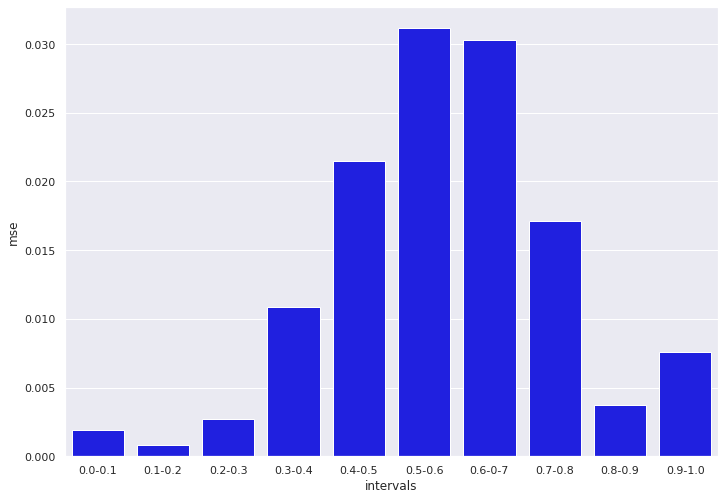

In [28]:
range_values = np.arange(0.05,1.05,0.1)
mse_ranges = []
print(range_values)
for val in range_values:
    labels_range = y_test[np.where(np.abs(y_test-val)<=0.05)]
    correspondent_predictions = predictions[np.where(np.abs(y_test-val)<=0.05)]
    mse_ranges.append(MSE(correspondent_predictions, labels_range))
sns.set(rc={'figure.figsize':(11.7,8.27)})
intervals = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5', '0.5-0.6', '0.6-0-7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
dict_mse = {'intervals': intervals, 'mse': mse_ranges}
df_mse = pd.DataFrame.from_dict(dict_mse)
sns.barplot(x = df_mse['intervals'], y = df_mse['mse'], color='blue')
plt.show()

In [31]:
params = { 'max_depth': [5, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.5, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
            }
score = make_scorer(penalized_MSE_train, greater_is_better=False)
model = XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator = model,
                         param_distributions = params,
                         scoring = score,
                         n_iter=10,
                         verbose=10)
clf.fit(x_train, y_train,eval_metric = penalized_MSE_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bylevel=0.7, colsample_bytree=0.5, learning_rate=0.1, max_depth=20, n_estimators=1000, subsample=0.8999999999999999
[19:50:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:775: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "<ipython-input-22-fc5a6eefbb96>", line 5, in penalized_MSE_train
    return penalized_MSE_helper(sci.special.inv_boxcox(y_true, fitted_lambda),sci.special.inv_boxcox(y_pred, fitted_lambda))
  File "<ipython-input-18-35a842ea6f90>", line 7, in penalized_MSE_helper
    return 1/2*MSE(critical_y, criti

[CV 1/5; 1/10] END colsample_bylevel=0.7, colsample_bytree=0.5, learning_rate=0.1, max_depth=20, n_estimators=1000, subsample=0.8999999999999999;, score=nan total time= 3.8min
[CV 2/5; 1/10] START colsample_bylevel=0.7, colsample_bytree=0.5, learning_rate=0.1, max_depth=20, n_estimators=1000, subsample=0.8999999999999999
[19:53:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored